In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
import warnings
from sklearn.model_selection import cross_val_score

In [87]:
int_z = pd.read_csv("./data/protein_intensity_zscore.csv", index_col=0)
print(int_z.shape)
int_z.head()

(317, 295)


,sp|A0AVT1|UBA6_HUMAN,sp|O00170|AIP_HUMAN,sp|O00299|CLIC1_HUMAN,sp|O00429|DNM1L_HUMAN,sp|O00483|NDUA4_HUMAN,sp|O00571|DDX3X_HUMAN,sp|O14828|SCAM3_HUMAN,sp|O14929|HAT1_HUMAN,sp|O15143|ARC1B_HUMAN,sp|O15145|ARPC3_HUMAN,...,sp|Q9Y230|RUVB2_HUMAN,sp|Q9Y285|SYFA_HUMAN,sp|Q9Y2B0|CNPY2_HUMAN,sp|Q9Y2X3|NOP58_HUMAN,sp|Q9Y383|LC7L2_HUMAN,sp|Q9Y4L1|HYOU1_HUMAN,sp|Q9Y5K5|UCHL5_HUMAN,sp|Q9Y5M8|SRPRB_HUMAN,sp|Q9Y5X3|SNX5_HUMAN,sp|Q9Y678|COPG1_HUMAN
CTG-0158,0.209381,0.653023,-1.099790,-0.667674,-0.464784,-1.104040,1.064904,1.212303,-0.105195,0.262680,...,-0.225060,-0.582061,0.190608,0.523718,0.930487,1.973644,-0.112272,-0.273877,0.404153,0.438980
CTG-0159,-0.183999,-0.018782,-0.312036,-0.948859,-1.043242,-0.598977,-2.682560,-0.309840,0.367815,0.505647,...,0.799988,-0.250965,0.157779,0.449693,0.378730,-0.793708,0.306690,0.095518,-0.827194,0.838111
CTG-0160,-0.670887,-0.722578,-0.093358,0.312980,-0.700072,-0.775965,-0.260419,0.263832,-0.330908,0.082317,...,-0.831781,-0.588702,-0.197368,-0.694927,-0.683281,-1.228597,0.123870,-0.048293,0.012048,0.103660
CTG-0162,-0.881549,0.670249,-0.415621,-0.210967,1.441151,-0.533146,0.939227,0.404382,-0.155148,-0.084630,...,0.455833,1.050649,2.515476,1.225294,0.428778,1.299635,-0.105924,3.077463,-0.389687,2.550997
CTG-0163,-1.043845,-0.962508,-1.216163,0.960054,0.309920,-0.600056,-0.611172,1.245767,-0.794668,0.131507,...,-0.496527,-0.141865,-1.274745,-0.089472,-0.318291,-0.880406,0.021034,0.106797,0.182648,0.331377


In [130]:
N_SPLITS = 5
rng = np.random.RandomState(0)
n_sub = 10

# subset data for faster run
for i in tqdm(range(n_sub), total=n_sub):
    y_full = np.array(int_z.iloc[:, i])
    X_full = np.array(int_z.drop(int_z.columns[i], axis=1).iloc[:, 1:n_sub])
    X_full = X_full[::10]
    y_full = y_full[::10]
    n_samples, n_features = X_full.shape

    br_estimator = BayesianRidge()

    # Add missing values
    X_missing = X_full.copy()
    y_missing = y_full
    missing_samples = np.arange(n_samples)
    missing_features = rng.choice(n_features, n_samples, replace=True)
    X_missing[missing_samples, missing_features] = np.nan

    # Estimate the score after imputation (mean and median strategies)
    score_simple_imputer = pd.DataFrame()
    for strategy in ("mean", "median"):
        estimator = make_pipeline(
            SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
        )
        score_simple_imputer[strategy] = cross_val_score(
            estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
        )

    # Estimate the score after iterative imputation of the missing values
    # with different estimators
    estimators = [
        KNeighborsRegressor(n_neighbors=6),
        RandomForestRegressor(n_estimators=100, random_state=0)
    ]
    score_iterative_imputer = pd.DataFrame()
    warnings.filterwarnings("ignore")
    for impute_estimator in estimators:
        estimator = make_pipeline(
            IterativeImputer(random_state=0, estimator=impute_estimator), br_estimator
        )
        score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
            estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
        )
    score_iterative_imputer = score_iterative_imputer.rename(columns={"KNeighborsRegressor": "kNN", 
                                                                      "RandomForestRegressor": "Random_Forest"})

    if i==0:
        scores = pd.concat(
            [score_simple_imputer, score_iterative_imputer],
            keys=["Simple", "ML"],
            axis=1
        )
    else:
        scores = scores + pd.concat(
            [score_simple_imputer, score_iterative_imputer],
            keys=["Simple", "ML"],
            axis=1
        )

scores = scores/n_sub
scores

100%|██████████| 10/10 [05:09<00:00, 30.91s/it]


Simple                  ML              
       mean    median       kNN Random_Forest
0 -0.753605 -0.752752 -0.748214     -0.750098
1 -0.862692 -0.866439 -0.899809     -0.882019
2 -1.192157 -1.187011 -1.185573     -1.206209
3 -0.902354 -0.908222 -0.898722     -0.907219
4 -1.301079 -1.297877 -1.321307     -1.295293

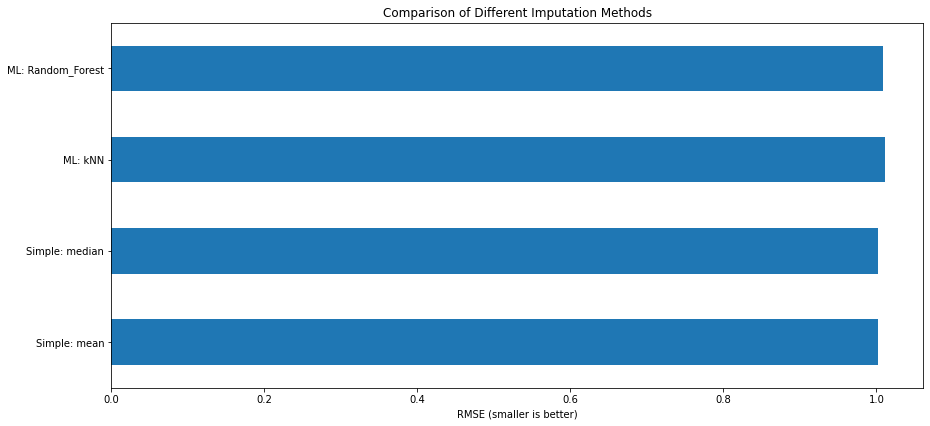

In [131]:
# plot results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
# errors = scores.std()
# means.plot.barh(xerr=errors, ax=ax)
means.plot.barh(ax=ax)
ax.set_title("Comparison of Different Imputation Methods")
ax.set_xlabel("RMSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([": ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()